In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import optuna

# Paths
base_path = '../Competition_data'
dataset_folders = os.listdir(base_path)

In [2]:
# Define a function for hyperparameter tuning using Optuna
def tune_nn_model(trial, input_dim):
    model = Sequential()
    # Suggest number of units for each layer
    n_units_1 = trial.suggest_int('n_units_1', 64, 256)
    n_units_2 = trial.suggest_int('n_units_2', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)

    model.add(Dense(n_units_1, input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_units_2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [3]:
# Initialize lists to store summary metrics for all datasets
summary_metrics = []

# Loop through each dataset folder
for dataset in dataset_folders:
    dataset_path = os.path.join(base_path, dataset)

    # Load data
    X_train = pd.read_csv(os.path.join(dataset_path, 'X_train.csv'))
    y_train = pd.read_csv(os.path.join(dataset_path, 'y_train.csv'))
    X_test = pd.read_csv(os.path.join(dataset_path, 'X_test.csv'))

    # Step 1: Standardize the feature values
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Step 2: Dimensionality Reduction using PCA (keep 95% variance)
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Combine PCA-transformed features with the target
    X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC_{i+1}' for i in range(X_train_pca.shape[1])])
    X_train_combined = pd.concat([X_train_pca_df, y_train], axis=1)

    # Train Test Split
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)

    # Verify data shapes
    print(f"Dataset: {dataset}")
    print("X_train_split shape:", X_train_split.shape)
    print("y_train_split shape:", y_train_split.shape)
    print("X_val shape:", X_val.shape)
    print("y_val shape:", y_val.shape)

    # Hyperparameter Tuning with Optuna
    def objective(trial):
        try:
            model = Sequential()
            model.add(Dense(trial.suggest_int('n_units_1', 32, 128), input_dim=X_train_split.shape[1], activation='relu'))
            model.add(Dropout(trial.suggest_float('dropout_rate', 0.2, 0.5)))
            model.add(Dense(trial.suggest_int('n_units_2', 32, 128), activation='relu'))
            model.add(Dropout(trial.suggest_float('dropout_rate', 0.2, 0.5)))
            model.add(Dense(1, activation='sigmoid'))

            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            history = model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=0)
            val_accuracy = max(history.history['val_accuracy'])
            return val_accuracy
        except Exception as e:
            print(f"Trial failed due to: {e}")
            return None

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)

    # Train Final Model with Best Parameters
    best_params = study.best_params
    model = Sequential()
    model.add(Dense(best_params['n_units_1'], input_dim=X_train_split.shape[1], activation='relu'))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(best_params['n_units_2'], activation='relu'))
    model.add(Dropout(best_params['dropout_rate']))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train_split, y_train_split, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)

    # Evaluate the Model
    y_val_pred = (model.predict(X_val) > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    # Custom Score
    score = accuracy * 0.3 + precision * 0.4 + f1 * 0.3
    print(f"Dataset: {dataset}, Score: {score:.4f}")

    # Store metrics for summary
    summary_metrics.append({
        'Dataset': dataset,
        'Accuracy': accuracy,
        'Precision': precision,
        'F1 Score': f1,
        'Score': score
    })

    # Inference on Test Set
    y_test_pred = model.predict(X_test_pca)
    y_test_pred_percentage = y_test_pred.flatten()  # Keep values between 0.0 and 1.0 for probability of 1

    # Save Predictions
    y_predict_path = os.path.join(dataset_path, 'y_predict.csv')
    pd.DataFrame({'Prediction': y_test_pred_percentage}).to_csv(y_predict_path, index=False)


[I 2024-11-06 22:29:50,669] A new study created in memory with name: no-name-d50d0949-63f5-49f2-b177-a321debeeadc


Dataset: Dataset_2
X_train_split shape: (372, 9)
y_train_split shape: (372, 1)
X_val shape: (93, 9)
y_val shape: (93, 1)


[I 2024-11-06 22:29:51,558] Trial 0 finished with value: 0.9892473220825195 and parameters: {'n_units_1': 88, 'dropout_rate': 0.33039055719993354, 'n_units_2': 127}. Best is trial 0 with value: 0.9892473220825195.
[I 2024-11-06 22:29:52,410] Trial 1 finished with value: 0.9892473220825195 and parameters: {'n_units_1': 119, 'dropout_rate': 0.3128628932625851, 'n_units_2': 112}. Best is trial 0 with value: 0.9892473220825195.
[I 2024-11-06 22:29:53,368] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 114, 'dropout_rate': 0.2265172289018271, 'n_units_2': 106}. Best is trial 2 with value: 1.0.
[I 2024-11-06 22:29:54,309] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 128, 'dropout_rate': 0.3682658465895128, 'n_units_2': 61}. Best is trial 2 with value: 1.0.
[I 2024-11-06 22:29:55,150] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 93, 'dropout_rate': 0.35538217173815256, 'n_units_2': 88}. Best is trial 2 with value: 1.0.
[I 2024-11-06 22:29:55

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Dataset: Dataset_2, Score: 0.9704
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step


[I 2024-11-06 22:30:01,054] A new study created in memory with name: no-name-f86984a0-35dc-4a60-8459-a60c19fba43a


Dataset: Dataset_35
X_train_split shape: (368, 7)
y_train_split shape: (368, 1)
X_val shape: (92, 7)
y_val shape: (92, 1)


[I 2024-11-06 22:30:01,931] Trial 0 finished with value: 0.77173912525177 and parameters: {'n_units_1': 124, 'dropout_rate': 0.35957097424064854, 'n_units_2': 68}. Best is trial 0 with value: 0.77173912525177.
[I 2024-11-06 22:30:02,777] Trial 1 finished with value: 0.77173912525177 and parameters: {'n_units_1': 106, 'dropout_rate': 0.4835201561707726, 'n_units_2': 51}. Best is trial 0 with value: 0.77173912525177.
[I 2024-11-06 22:30:03,679] Trial 2 finished with value: 0.79347825050354 and parameters: {'n_units_1': 39, 'dropout_rate': 0.2696091265202402, 'n_units_2': 127}. Best is trial 2 with value: 0.79347825050354.
[I 2024-11-06 22:30:04,559] Trial 3 finished with value: 0.782608687877655 and parameters: {'n_units_1': 77, 'dropout_rate': 0.32466377997405604, 'n_units_2': 99}. Best is trial 2 with value: 0.79347825050354.
[I 2024-11-06 22:30:05,415] Trial 4 finished with value: 0.75 and parameters: {'n_units_1': 103, 'dropout_rate': 0.49390747643333277, 'n_units_2': 117}. Best is t

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Dataset: Dataset_35, Score: 0.7195
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


[I 2024-11-06 22:30:11,768] A new study created in memory with name: no-name-eb2c9712-68b5-443e-beda-f35aa38feeee


Dataset: Dataset_5
X_train_split shape: (259, 18)
y_train_split shape: (259, 1)
X_val shape: (65, 18)
y_val shape: (65, 1)


[I 2024-11-06 22:30:12,893] Trial 0 finished with value: 0.9230769276618958 and parameters: {'n_units_1': 117, 'dropout_rate': 0.343097520569999, 'n_units_2': 101}. Best is trial 0 with value: 0.9230769276618958.
[I 2024-11-06 22:30:13,808] Trial 1 finished with value: 0.9230769276618958 and parameters: {'n_units_1': 80, 'dropout_rate': 0.43711451412897495, 'n_units_2': 60}. Best is trial 0 with value: 0.9230769276618958.
[I 2024-11-06 22:30:14,687] Trial 2 finished with value: 0.9230769276618958 and parameters: {'n_units_1': 89, 'dropout_rate': 0.446564097005759, 'n_units_2': 62}. Best is trial 0 with value: 0.9230769276618958.
[I 2024-11-06 22:30:15,548] Trial 3 finished with value: 0.9230769276618958 and parameters: {'n_units_1': 40, 'dropout_rate': 0.35238049727219534, 'n_units_2': 47}. Best is trial 0 with value: 0.9230769276618958.
[I 2024-11-06 22:30:16,442] Trial 4 finished with value: 0.9384615421295166 and parameters: {'n_units_1': 81, 'dropout_rate': 0.27929324985136933, 'n_

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Dataset: Dataset_5, Score: 0.7815
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


[I 2024-11-06 22:30:22,783] A new study created in memory with name: no-name-831e0ff0-e985-4d2f-9ee9-738f3fc2b50d


Dataset: Dataset_32
X_train_split shape: (474, 4)
y_train_split shape: (474, 1)
X_val shape: (119, 4)
y_val shape: (119, 1)


[I 2024-11-06 22:30:23,707] Trial 0 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 109, 'dropout_rate': 0.4007194586597592, 'n_units_2': 104}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-06 22:30:24,596] Trial 1 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 75, 'dropout_rate': 0.27065650087026166, 'n_units_2': 90}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-06 22:30:25,465] Trial 2 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 35, 'dropout_rate': 0.2235150856994063, 'n_units_2': 120}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-06 22:30:26,346] Trial 3 finished with value: 0.8991596698760986 and parameters: {'n_units_1': 60, 'dropout_rate': 0.3697483303545399, 'n_units_2': 94}. Best is trial 3 with value: 0.8991596698760986.
[I 2024-11-06 22:30:27,239] Trial 4 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 101, 'dropout_rate': 0.378525685409186, 'n

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Dataset: Dataset_32, Score: 0.2672
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


[I 2024-11-06 22:30:33,714] A new study created in memory with name: no-name-0306c72b-6a73-4e51-80ea-c7e3116495ff


Dataset: Dataset_4
X_train_split shape: (411, 17)
y_train_split shape: (411, 1)
X_val shape: (103, 17)
y_val shape: (103, 1)


[I 2024-11-06 22:30:34,578] Trial 0 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 34, 'dropout_rate': 0.3655603119639821, 'n_units_2': 77}. Best is trial 0 with value: 0.9514563083648682.
[I 2024-11-06 22:30:35,437] Trial 1 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 49, 'dropout_rate': 0.241323414925459, 'n_units_2': 41}. Best is trial 0 with value: 0.9514563083648682.
[I 2024-11-06 22:30:36,305] Trial 2 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 95, 'dropout_rate': 0.2180889886703623, 'n_units_2': 110}. Best is trial 0 with value: 0.9514563083648682.
[I 2024-11-06 22:30:37,171] Trial 3 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 75, 'dropout_rate': 0.4613235656324548, 'n_units_2': 104}. Best is trial 0 with value: 0.9514563083648682.
[I 2024-11-06 22:30:38,036] Trial 4 finished with value: 0.9514563083648682 and parameters: {'n_units_1': 127, 'dropout_rate': 0.2183001831088174, 'n_u

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Dataset: Dataset_4, Score: 0.2854
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


[I 2024-11-06 22:30:44,736] A new study created in memory with name: no-name-9450ffd6-7a0a-4ed3-afbb-25976a83d67d


Dataset: Dataset_33
X_train_split shape: (192, 11)
y_train_split shape: (192, 1)
X_val shape: (48, 11)
y_val shape: (48, 1)


[I 2024-11-06 22:30:45,500] Trial 0 finished with value: 0.9791666865348816 and parameters: {'n_units_1': 113, 'dropout_rate': 0.24395822587575908, 'n_units_2': 117}. Best is trial 0 with value: 0.9791666865348816.
[I 2024-11-06 22:30:46,261] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 111, 'dropout_rate': 0.42873439010277536, 'n_units_2': 58}. Best is trial 1 with value: 1.0.
[I 2024-11-06 22:30:47,002] Trial 2 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 36, 'dropout_rate': 0.2342484716670509, 'n_units_2': 85}. Best is trial 1 with value: 1.0.
[I 2024-11-06 22:30:47,751] Trial 3 finished with value: 0.9791666865348816 and parameters: {'n_units_1': 125, 'dropout_rate': 0.2869320236932522, 'n_units_2': 112}. Best is trial 1 with value: 1.0.
[I 2024-11-06 22:30:48,490] Trial 4 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 66, 'dropout_rate': 0.3162828532329143, 'n_units_2': 54}. Best is trial 1 with value: 1.0.
[I 2024-

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_33, Score: 0.9611
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step


[I 2024-11-06 22:30:53,840] A new study created in memory with name: no-name-49c2cf46-c691-48cd-8be1-7021f6ca9bea


Dataset: Dataset_3
X_train_split shape: (55, 7)
y_train_split shape: (55, 1)
X_val shape: (14, 7)
y_val shape: (14, 1)


[I 2024-11-06 22:30:54,975] Trial 0 finished with value: 0.7857142686843872 and parameters: {'n_units_1': 80, 'dropout_rate': 0.3085342373659115, 'n_units_2': 39}. Best is trial 0 with value: 0.7857142686843872.
[I 2024-11-06 22:30:55,737] Trial 1 finished with value: 0.6428571343421936 and parameters: {'n_units_1': 94, 'dropout_rate': 0.2801539656556651, 'n_units_2': 99}. Best is trial 0 with value: 0.7857142686843872.
[I 2024-11-06 22:30:56,498] Trial 2 finished with value: 0.5714285969734192 and parameters: {'n_units_1': 50, 'dropout_rate': 0.28254757819839416, 'n_units_2': 87}. Best is trial 0 with value: 0.7857142686843872.
[I 2024-11-06 22:30:57,255] Trial 3 finished with value: 0.7142857313156128 and parameters: {'n_units_1': 82, 'dropout_rate': 0.44009683117167675, 'n_units_2': 93}. Best is trial 0 with value: 0.7857142686843872.
[I 2024-11-06 22:30:58,015] Trial 4 finished with value: 0.7857142686843872 and parameters: {'n_units_1': 64, 'dropout_rate': 0.44483868473204025, 'n_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Dataset: Dataset_3, Score: 0.7393
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-11-06 22:31:03,352] A new study created in memory with name: no-name-d524c412-1340-43d1-bb67-301099950a9a


Dataset: Dataset_34
X_train_split shape: (219, 7)
y_train_split shape: (219, 1)
X_val shape: (55, 7)
y_val shape: (55, 1)


[I 2024-11-06 22:31:04,186] Trial 0 finished with value: 0.800000011920929 and parameters: {'n_units_1': 43, 'dropout_rate': 0.39391418588531635, 'n_units_2': 70}. Best is trial 0 with value: 0.800000011920929.
[I 2024-11-06 22:31:04,992] Trial 1 finished with value: 0.7636363506317139 and parameters: {'n_units_1': 62, 'dropout_rate': 0.26599642656694045, 'n_units_2': 34}. Best is trial 0 with value: 0.800000011920929.
[I 2024-11-06 22:31:05,797] Trial 2 finished with value: 0.7818182110786438 and parameters: {'n_units_1': 110, 'dropout_rate': 0.2440890992994672, 'n_units_2': 107}. Best is trial 0 with value: 0.800000011920929.
[I 2024-11-06 22:31:06,597] Trial 3 finished with value: 0.800000011920929 and parameters: {'n_units_1': 37, 'dropout_rate': 0.4253145289832223, 'n_units_2': 116}. Best is trial 0 with value: 0.800000011920929.
[I 2024-11-06 22:31:07,398] Trial 4 finished with value: 0.800000011920929 and parameters: {'n_units_1': 59, 'dropout_rate': 0.29101247390091023, 'n_unit

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_34, Score: 0.7216
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step


[I 2024-11-06 22:31:13,530] A new study created in memory with name: no-name-c4d25432-cc38-497a-ba17-b251851b31c9


Dataset: Dataset_45
X_train_split shape: (126, 4)
y_train_split shape: (126, 1)
X_val shape: (32, 4)
y_val shape: (32, 1)


[I 2024-11-06 22:31:14,296] Trial 0 finished with value: 0.9375 and parameters: {'n_units_1': 42, 'dropout_rate': 0.2425206726624864, 'n_units_2': 114}. Best is trial 0 with value: 0.9375.
[I 2024-11-06 22:31:15,065] Trial 1 finished with value: 0.9375 and parameters: {'n_units_1': 91, 'dropout_rate': 0.3596866915866725, 'n_units_2': 82}. Best is trial 0 with value: 0.9375.
[I 2024-11-06 22:31:15,820] Trial 2 finished with value: 0.9375 and parameters: {'n_units_1': 80, 'dropout_rate': 0.3722783153601694, 'n_units_2': 65}. Best is trial 0 with value: 0.9375.
[I 2024-11-06 22:31:16,575] Trial 3 finished with value: 0.9375 and parameters: {'n_units_1': 127, 'dropout_rate': 0.29817624513423197, 'n_units_2': 59}. Best is trial 0 with value: 0.9375.
[I 2024-11-06 22:31:17,327] Trial 4 finished with value: 0.9375 and parameters: {'n_units_1': 56, 'dropout_rate': 0.2869434924986024, 'n_units_2': 110}. Best is trial 0 with value: 0.9375.
[I 2024-11-06 22:31:18,079] Trial 5 finished with value:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Dataset: Dataset_45, Score: 0.2812
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


[I 2024-11-06 22:31:22,749] A new study created in memory with name: no-name-9e96cb71-5876-451a-a12d-62c09013663c


Dataset: Dataset_42
X_train_split shape: (96, 5)
y_train_split shape: (96, 1)
X_val shape: (24, 5)
y_val shape: (24, 1)


[I 2024-11-06 22:31:23,481] Trial 0 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 99, 'dropout_rate': 0.4720082474720379, 'n_units_2': 122}. Best is trial 0 with value: 0.9583333134651184.
[I 2024-11-06 22:31:24,201] Trial 1 finished with value: 0.9583333134651184 and parameters: {'n_units_1': 54, 'dropout_rate': 0.21025817606870362, 'n_units_2': 42}. Best is trial 0 with value: 0.9583333134651184.
[I 2024-11-06 22:31:24,915] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 98, 'dropout_rate': 0.3188952854023594, 'n_units_2': 98}. Best is trial 2 with value: 1.0.
[I 2024-11-06 22:31:25,624] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 56, 'dropout_rate': 0.36509837631213976, 'n_units_2': 61}. Best is trial 2 with value: 1.0.
[I 2024-11-06 22:31:26,867] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 44, 'dropout_rate': 0.4058903493097079, 'n_units_2': 34}. Best is trial 2 with value: 1.0.
[I 2024-11-06 22:31:27,601]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_42, Score: 0.9755
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


[I 2024-11-06 22:31:32,048] A new study created in memory with name: no-name-5004bb38-110c-4c4e-b3cd-130c3164cbef


Dataset: Dataset_27
X_train_split shape: (164, 5)
y_train_split shape: (164, 1)
X_val shape: (42, 5)
y_val shape: (42, 1)


[I 2024-11-06 22:31:32,873] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 76, 'dropout_rate': 0.3386683666652665, 'n_units_2': 65}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:31:33,669] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 51, 'dropout_rate': 0.2348889331152263, 'n_units_2': 127}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:31:34,471] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 61, 'dropout_rate': 0.2772137832280092, 'n_units_2': 115}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:31:35,267] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 46, 'dropout_rate': 0.35001022192814774, 'n_units_2': 57}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:31:36,072] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 115, 'dropout_rate': 0.2280607763688393, 'n_units_2': 103}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:31:36,875] Trial 5 finished with value: 1.0 and parameters: {'n_unit

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_27, Score: 1.0000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step


[I 2024-11-06 22:31:41,670] A new study created in memory with name: no-name-08c8f282-8878-46fd-9b66-b787c55d12eb


Dataset: Dataset_18
X_train_split shape: (272, 12)
y_train_split shape: (272, 1)
X_val shape: (68, 12)
y_val shape: (68, 1)


[I 2024-11-06 22:31:42,515] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 116, 'dropout_rate': 0.4986492009675725, 'n_units_2': 96}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:31:43,346] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 62, 'dropout_rate': 0.40512759865224174, 'n_units_2': 76}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:31:44,171] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 52, 'dropout_rate': 0.22802420384121524, 'n_units_2': 120}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:31:44,994] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 104, 'dropout_rate': 0.23831209391572836, 'n_units_2': 82}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:31:45,819] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 109, 'dropout_rate': 0.42701886037566494, 'n_units_2': 64}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:31:46,639] Trial 5 finished with value: 1.0 and parameters: {'n_u

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_18, Score: 1.0000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step


[I 2024-11-06 22:31:52,358] A new study created in memory with name: no-name-f9725651-79c9-4c55-baaf-926a7deaac2a


Dataset: Dataset_20
X_train_split shape: (103, 11)
y_train_split shape: (103, 1)
X_val shape: (26, 11)
y_val shape: (26, 1)


[I 2024-11-06 22:31:53,258] Trial 0 finished with value: 0.7307692170143127 and parameters: {'n_units_1': 46, 'dropout_rate': 0.41923544529301954, 'n_units_2': 65}. Best is trial 0 with value: 0.7307692170143127.
[I 2024-11-06 22:31:54,086] Trial 1 finished with value: 0.8461538553237915 and parameters: {'n_units_1': 83, 'dropout_rate': 0.20073534909197752, 'n_units_2': 109}. Best is trial 1 with value: 0.8461538553237915.
[I 2024-11-06 22:31:54,876] Trial 2 finished with value: 0.8846153616905212 and parameters: {'n_units_1': 98, 'dropout_rate': 0.2818593657530603, 'n_units_2': 67}. Best is trial 2 with value: 0.8846153616905212.
[I 2024-11-06 22:31:55,649] Trial 3 finished with value: 0.8846153616905212 and parameters: {'n_units_1': 80, 'dropout_rate': 0.24787359471597878, 'n_units_2': 128}. Best is trial 2 with value: 0.8846153616905212.
[I 2024-11-06 22:31:56,423] Trial 4 finished with value: 0.807692289352417 and parameters: {'n_units_1': 88, 'dropout_rate': 0.4340097662170755, 'n

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_20, Score: 0.7519
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step


[I 2024-11-06 22:32:02,131] A new study created in memory with name: no-name-7e26cc0c-5194-403c-a866-33c8329be3d7


Dataset: Dataset_16
X_train_split shape: (372, 9)
y_train_split shape: (372, 1)
X_val shape: (93, 9)
y_val shape: (93, 1)


[I 2024-11-06 22:32:03,009] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 108, 'dropout_rate': 0.2891113808028374, 'n_units_2': 56}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:32:03,866] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 78, 'dropout_rate': 0.4322475380882705, 'n_units_2': 117}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:32:04,724] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 52, 'dropout_rate': 0.21840932952002465, 'n_units_2': 56}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:32:05,585] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 86, 'dropout_rate': 0.43336179641864203, 'n_units_2': 126}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:32:06,451] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 112, 'dropout_rate': 0.3614701202811032, 'n_units_2': 123}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:32:07,332] Trial 5 finished with value: 1.0 and parameters: {'n_un

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Dataset: Dataset_16, Score: 0.9854
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


[I 2024-11-06 22:32:12,466] A new study created in memory with name: no-name-1e111ed4-3f0e-4b0a-a867-78c0a604692f


Dataset: Dataset_29
X_train_split shape: (244, 10)
y_train_split shape: (244, 1)
X_val shape: (62, 10)
y_val shape: (62, 1)


[I 2024-11-06 22:32:14,176] Trial 0 finished with value: 0.7580645084381104 and parameters: {'n_units_1': 124, 'dropout_rate': 0.4209449552956897, 'n_units_2': 36}. Best is trial 0 with value: 0.7580645084381104.
[I 2024-11-06 22:32:15,119] Trial 1 finished with value: 0.774193525314331 and parameters: {'n_units_1': 86, 'dropout_rate': 0.4261079991526529, 'n_units_2': 42}. Best is trial 1 with value: 0.774193525314331.
[I 2024-11-06 22:32:15,966] Trial 2 finished with value: 0.7580645084381104 and parameters: {'n_units_1': 56, 'dropout_rate': 0.4799989968779108, 'n_units_2': 111}. Best is trial 1 with value: 0.774193525314331.
[I 2024-11-06 22:32:16,791] Trial 3 finished with value: 0.774193525314331 and parameters: {'n_units_1': 61, 'dropout_rate': 0.3933291012718808, 'n_units_2': 109}. Best is trial 1 with value: 0.774193525314331.
[I 2024-11-06 22:32:17,610] Trial 4 finished with value: 0.8064516186714172 and parameters: {'n_units_1': 84, 'dropout_rate': 0.2572118790899648, 'n_units

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_29, Score: 0.8565
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step


[I 2024-11-06 22:32:23,509] A new study created in memory with name: no-name-2dbc7e98-3dda-4872-972a-ad23a401ee61


Dataset: Dataset_11
X_train_split shape: (46, 20)
y_train_split shape: (46, 1)
X_val shape: (12, 20)
y_val shape: (12, 1)


[I 2024-11-06 22:32:24,415] Trial 0 finished with value: 0.5833333134651184 and parameters: {'n_units_1': 36, 'dropout_rate': 0.48155151748103775, 'n_units_2': 37}. Best is trial 0 with value: 0.5833333134651184.
[I 2024-11-06 22:32:25,186] Trial 1 finished with value: 0.5833333134651184 and parameters: {'n_units_1': 95, 'dropout_rate': 0.40047895707935327, 'n_units_2': 35}. Best is trial 0 with value: 0.5833333134651184.
[I 2024-11-06 22:32:25,946] Trial 2 finished with value: 0.75 and parameters: {'n_units_1': 58, 'dropout_rate': 0.4178565827840432, 'n_units_2': 42}. Best is trial 2 with value: 0.75.
[I 2024-11-06 22:32:26,699] Trial 3 finished with value: 0.6666666865348816 and parameters: {'n_units_1': 36, 'dropout_rate': 0.4373253008312601, 'n_units_2': 91}. Best is trial 2 with value: 0.75.
[I 2024-11-06 22:32:27,453] Trial 4 finished with value: 0.5833333134651184 and parameters: {'n_units_1': 62, 'dropout_rate': 0.2686606379898969, 'n_units_2': 58}. Best is trial 2 with value: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Dataset: Dataset_11, Score: 0.1500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step


[I 2024-11-06 22:32:32,994] A new study created in memory with name: no-name-93429ab7-9299-4c54-91a6-cccc7b23e7b7


Dataset: Dataset_43
X_train_split shape: (474, 4)
y_train_split shape: (474, 1)
X_val shape: (119, 4)
y_val shape: (119, 1)


[I 2024-11-06 22:32:33,905] Trial 0 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 68, 'dropout_rate': 0.48002077877352245, 'n_units_2': 36}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-06 22:32:34,794] Trial 1 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 82, 'dropout_rate': 0.37605234113759173, 'n_units_2': 110}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-06 22:32:35,677] Trial 2 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 50, 'dropout_rate': 0.2583122160165581, 'n_units_2': 99}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-06 22:32:36,558] Trial 3 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 108, 'dropout_rate': 0.46036652812716855, 'n_units_2': 40}. Best is trial 0 with value: 0.8907563090324402.
[I 2024-11-06 22:32:37,440] Trial 4 finished with value: 0.8907563090324402 and parameters: {'n_units_1': 36, 'dropout_rate': 0.443932727202032, 'n

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
Dataset: Dataset_43, Score: 0.2672
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step


[I 2024-11-06 22:32:44,946] A new study created in memory with name: no-name-1ebe52c9-8410-4850-a726-b4cb792de5a3


Dataset: Dataset_44
X_train_split shape: (48, 6)
y_train_split shape: (48, 1)
X_val shape: (12, 6)
y_val shape: (12, 1)


[I 2024-11-06 22:32:45,790] Trial 0 finished with value: 1.0 and parameters: {'n_units_1': 53, 'dropout_rate': 0.26142443454347336, 'n_units_2': 83}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:32:46,577] Trial 1 finished with value: 1.0 and parameters: {'n_units_1': 114, 'dropout_rate': 0.32843380377017745, 'n_units_2': 114}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:32:47,351] Trial 2 finished with value: 1.0 and parameters: {'n_units_1': 97, 'dropout_rate': 0.4396462725943899, 'n_units_2': 39}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:32:48,121] Trial 3 finished with value: 1.0 and parameters: {'n_units_1': 104, 'dropout_rate': 0.44268795334735817, 'n_units_2': 83}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:32:48,880] Trial 4 finished with value: 1.0 and parameters: {'n_units_1': 125, 'dropout_rate': 0.23611692682789567, 'n_units_2': 127}. Best is trial 0 with value: 1.0.
[I 2024-11-06 22:32:49,647] Trial 5 finished with value: 1.0 and parameters: {'n_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_44, Score: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


[I 2024-11-06 22:32:54,473] A new study created in memory with name: no-name-f66afe3c-c5c1-4a44-b638-a8e568436808


Dataset: Dataset_10
X_train_split shape: (373, 8)
y_train_split shape: (373, 1)
X_val shape: (94, 8)
y_val shape: (94, 1)


[I 2024-11-06 22:32:55,375] Trial 0 finished with value: 0.7234042286872864 and parameters: {'n_units_1': 119, 'dropout_rate': 0.3495040986657582, 'n_units_2': 60}. Best is trial 0 with value: 0.7234042286872864.
[I 2024-11-06 22:32:56,233] Trial 1 finished with value: 0.7127659320831299 and parameters: {'n_units_1': 35, 'dropout_rate': 0.3217061272455559, 'n_units_2': 82}. Best is trial 0 with value: 0.7234042286872864.
[I 2024-11-06 22:32:57,099] Trial 2 finished with value: 0.7127659320831299 and parameters: {'n_units_1': 61, 'dropout_rate': 0.22729497426270168, 'n_units_2': 79}. Best is trial 0 with value: 0.7234042286872864.
[I 2024-11-06 22:32:57,979] Trial 3 finished with value: 0.7127659320831299 and parameters: {'n_units_1': 100, 'dropout_rate': 0.23061778630592622, 'n_units_2': 107}. Best is trial 0 with value: 0.7234042286872864.
[I 2024-11-06 22:32:58,863] Trial 4 finished with value: 0.7021276354789734 and parameters: {'n_units_1': 113, 'dropout_rate': 0.457672826381805, '

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Dataset: Dataset_10, Score: 0.6480
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step


[I 2024-11-06 22:33:05,092] A new study created in memory with name: no-name-bda2109f-755a-4846-9876-517868653fd7


Dataset: Dataset_17
X_train_split shape: (96, 16)
y_train_split shape: (96, 1)
X_val shape: (24, 16)
y_val shape: (24, 1)


[I 2024-11-06 22:33:05,839] Trial 0 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 68, 'dropout_rate': 0.47207661266214795, 'n_units_2': 50}. Best is trial 0 with value: 0.8333333134651184.
[I 2024-11-06 22:33:06,555] Trial 1 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 58, 'dropout_rate': 0.2134839655777084, 'n_units_2': 97}. Best is trial 0 with value: 0.8333333134651184.
[I 2024-11-06 22:33:07,276] Trial 2 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 121, 'dropout_rate': 0.20783062750032621, 'n_units_2': 63}. Best is trial 0 with value: 0.8333333134651184.
[I 2024-11-06 22:33:07,991] Trial 3 finished with value: 0.875 and parameters: {'n_units_1': 126, 'dropout_rate': 0.4704062846120316, 'n_units_2': 35}. Best is trial 3 with value: 0.875.
[I 2024-11-06 22:33:08,702] Trial 4 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 70, 'dropout_rate': 0.20196579888210908, 'n_units_2': 60}. Best is t

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_17, Score: 0.8775
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


[I 2024-11-06 22:33:14,188] A new study created in memory with name: no-name-b538a831-0419-40d4-aa9c-334d8796762d


Dataset: Dataset_28
X_train_split shape: (368, 7)
y_train_split shape: (368, 1)
X_val shape: (92, 7)
y_val shape: (92, 1)


[I 2024-11-06 22:33:15,077] Trial 0 finished with value: 0.782608687877655 and parameters: {'n_units_1': 64, 'dropout_rate': 0.23430052379242963, 'n_units_2': 105}. Best is trial 0 with value: 0.782608687877655.
[I 2024-11-06 22:33:15,941] Trial 1 finished with value: 0.79347825050354 and parameters: {'n_units_1': 56, 'dropout_rate': 0.24398099990446875, 'n_units_2': 67}. Best is trial 1 with value: 0.79347825050354.
[I 2024-11-06 22:33:16,801] Trial 2 finished with value: 0.760869562625885 and parameters: {'n_units_1': 104, 'dropout_rate': 0.48165167183198615, 'n_units_2': 87}. Best is trial 1 with value: 0.79347825050354.
[I 2024-11-06 22:33:18,949] Trial 3 finished with value: 0.79347825050354 and parameters: {'n_units_1': 86, 'dropout_rate': 0.24517596837717126, 'n_units_2': 94}. Best is trial 1 with value: 0.79347825050354.
[I 2024-11-06 22:33:20,128] Trial 4 finished with value: 0.79347825050354 and parameters: {'n_units_1': 110, 'dropout_rate': 0.37848968438239133, 'n_units_2': 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_28, Score: 0.7173
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step


[I 2024-11-06 22:33:26,181] A new study created in memory with name: no-name-2edbdd99-9847-4658-b8a9-556d96909bda


Dataset: Dataset_21
X_train_split shape: (242, 11)
y_train_split shape: (242, 1)
X_val shape: (61, 11)
y_val shape: (61, 1)


[I 2024-11-06 22:33:27,050] Trial 0 finished with value: 0.868852436542511 and parameters: {'n_units_1': 92, 'dropout_rate': 0.3992271077308995, 'n_units_2': 50}. Best is trial 0 with value: 0.868852436542511.
[I 2024-11-06 22:33:27,880] Trial 1 finished with value: 0.8360655903816223 and parameters: {'n_units_1': 115, 'dropout_rate': 0.4771086057532678, 'n_units_2': 37}. Best is trial 0 with value: 0.868852436542511.
[I 2024-11-06 22:33:28,795] Trial 2 finished with value: 0.8360655903816223 and parameters: {'n_units_1': 119, 'dropout_rate': 0.29279695643507647, 'n_units_2': 48}. Best is trial 0 with value: 0.868852436542511.
[I 2024-11-06 22:33:29,623] Trial 3 finished with value: 0.868852436542511 and parameters: {'n_units_1': 114, 'dropout_rate': 0.42245895805404693, 'n_units_2': 95}. Best is trial 0 with value: 0.868852436542511.
[I 2024-11-06 22:33:30,450] Trial 4 finished with value: 0.868852436542511 and parameters: {'n_units_1': 63, 'dropout_rate': 0.3624427002446269, 'n_units

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_21, Score: 0.8251
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


[I 2024-11-06 22:33:36,333] A new study created in memory with name: no-name-34519b27-6ab9-493f-91f0-b2f9db011bd4


Dataset: Dataset_26
X_train_split shape: (143, 22)
y_train_split shape: (143, 1)
X_val shape: (36, 22)
y_val shape: (36, 1)


[I 2024-11-06 22:33:37,158] Trial 0 finished with value: 0.7777777910232544 and parameters: {'n_units_1': 113, 'dropout_rate': 0.4596586656321327, 'n_units_2': 38}. Best is trial 0 with value: 0.7777777910232544.
[I 2024-11-06 22:33:37,952] Trial 1 finished with value: 0.8055555820465088 and parameters: {'n_units_1': 58, 'dropout_rate': 0.31745786048495245, 'n_units_2': 101}. Best is trial 1 with value: 0.8055555820465088.
[I 2024-11-06 22:33:38,748] Trial 2 finished with value: 0.8055555820465088 and parameters: {'n_units_1': 120, 'dropout_rate': 0.42916149461708003, 'n_units_2': 62}. Best is trial 1 with value: 0.8055555820465088.
[I 2024-11-06 22:33:39,542] Trial 3 finished with value: 0.75 and parameters: {'n_units_1': 103, 'dropout_rate': 0.22093851432975342, 'n_units_2': 52}. Best is trial 1 with value: 0.8055555820465088.
[I 2024-11-06 22:33:40,337] Trial 4 finished with value: 0.8055555820465088 and parameters: {'n_units_1': 69, 'dropout_rate': 0.3821386355475356, 'n_units_2': 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_26, Score: 0.6303
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


[I 2024-11-06 22:33:46,041] A new study created in memory with name: no-name-52c65b97-7c9f-4f6c-a1fd-902c64d59ded


Dataset: Dataset_19
X_train_split shape: (272, 10)
y_train_split shape: (272, 1)
X_val shape: (69, 10)
y_val shape: (69, 1)


[I 2024-11-06 22:33:46,926] Trial 0 finished with value: 0.9275362491607666 and parameters: {'n_units_1': 111, 'dropout_rate': 0.2342426054883857, 'n_units_2': 80}. Best is trial 0 with value: 0.9275362491607666.
[I 2024-11-06 22:33:47,768] Trial 1 finished with value: 0.9275362491607666 and parameters: {'n_units_1': 77, 'dropout_rate': 0.29843339540900315, 'n_units_2': 37}. Best is trial 0 with value: 0.9275362491607666.
[I 2024-11-06 22:33:48,613] Trial 2 finished with value: 0.9420289993286133 and parameters: {'n_units_1': 118, 'dropout_rate': 0.3997386429864476, 'n_units_2': 125}. Best is trial 2 with value: 0.9420289993286133.
[I 2024-11-06 22:33:49,449] Trial 3 finished with value: 0.9420289993286133 and parameters: {'n_units_1': 113, 'dropout_rate': 0.489341611043544, 'n_units_2': 101}. Best is trial 2 with value: 0.9420289993286133.
[I 2024-11-06 22:33:50,278] Trial 4 finished with value: 0.9420289993286133 and parameters: {'n_units_1': 64, 'dropout_rate': 0.3842876110060758, '

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_19, Score: 0.9081
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step


[I 2024-11-06 22:33:56,567] A new study created in memory with name: no-name-335ceb2f-d6c3-478a-b025-b9c067bec4f3


Dataset: Dataset_8
X_train_split shape: (143, 11)
y_train_split shape: (143, 1)
X_val shape: (36, 11)
y_val shape: (36, 1)


[I 2024-11-06 22:33:57,422] Trial 0 finished with value: 0.8055555820465088 and parameters: {'n_units_1': 49, 'dropout_rate': 0.261982544349731, 'n_units_2': 128}. Best is trial 0 with value: 0.8055555820465088.
[I 2024-11-06 22:33:59,919] Trial 1 finished with value: 0.8888888955116272 and parameters: {'n_units_1': 76, 'dropout_rate': 0.3667524567573925, 'n_units_2': 120}. Best is trial 1 with value: 0.8888888955116272.
[I 2024-11-06 22:34:00,816] Trial 2 finished with value: 0.7777777910232544 and parameters: {'n_units_1': 94, 'dropout_rate': 0.3579184335197475, 'n_units_2': 126}. Best is trial 1 with value: 0.8888888955116272.
[I 2024-11-06 22:34:01,675] Trial 3 finished with value: 0.75 and parameters: {'n_units_1': 38, 'dropout_rate': 0.3154486751912896, 'n_units_2': 116}. Best is trial 1 with value: 0.8888888955116272.
[I 2024-11-06 22:34:02,785] Trial 4 finished with value: 0.8055555820465088 and parameters: {'n_units_1': 67, 'dropout_rate': 0.30616800940730476, 'n_units_2': 44}

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_8, Score: 0.7840
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step


[I 2024-11-06 22:34:08,352] A new study created in memory with name: no-name-4c7c521e-790a-4dd3-916d-55b0276adaf8


Dataset: Dataset_38
X_train_split shape: (279, 8)
y_train_split shape: (279, 1)
X_val shape: (70, 8)
y_val shape: (70, 1)


[I 2024-11-06 22:34:09,216] Trial 0 finished with value: 0.7142857313156128 and parameters: {'n_units_1': 96, 'dropout_rate': 0.4313112070392075, 'n_units_2': 35}. Best is trial 0 with value: 0.7142857313156128.
[I 2024-11-06 22:34:10,055] Trial 1 finished with value: 0.7285714149475098 and parameters: {'n_units_1': 104, 'dropout_rate': 0.242570637009921, 'n_units_2': 41}. Best is trial 1 with value: 0.7285714149475098.
[I 2024-11-06 22:34:10,894] Trial 2 finished with value: 0.7285714149475098 and parameters: {'n_units_1': 35, 'dropout_rate': 0.23236019516685988, 'n_units_2': 73}. Best is trial 1 with value: 0.7285714149475098.
[I 2024-11-06 22:34:11,728] Trial 3 finished with value: 0.7285714149475098 and parameters: {'n_units_1': 64, 'dropout_rate': 0.354051204291929, 'n_units_2': 69}. Best is trial 1 with value: 0.7285714149475098.
[I 2024-11-06 22:34:12,570] Trial 4 finished with value: 0.7285714149475098 and parameters: {'n_units_1': 115, 'dropout_rate': 0.396953612378661, 'n_uni

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
Dataset: Dataset_38, Score: 0.7371
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


[I 2024-11-06 22:34:18,571] A new study created in memory with name: no-name-1a977f2c-a229-4ee9-a851-5e000302fb42


Dataset: Dataset_6
X_train_split shape: (249, 14)
y_train_split shape: (249, 1)
X_val shape: (63, 14)
y_val shape: (63, 1)


[I 2024-11-06 22:34:19,475] Trial 0 finished with value: 0.8888888955116272 and parameters: {'n_units_1': 58, 'dropout_rate': 0.4878821142059993, 'n_units_2': 41}. Best is trial 0 with value: 0.8888888955116272.
[I 2024-11-06 22:34:20,312] Trial 1 finished with value: 0.9047619104385376 and parameters: {'n_units_1': 95, 'dropout_rate': 0.3994566269417094, 'n_units_2': 55}. Best is trial 1 with value: 0.9047619104385376.
[I 2024-11-06 22:34:21,145] Trial 2 finished with value: 0.920634925365448 and parameters: {'n_units_1': 87, 'dropout_rate': 0.48043408699028833, 'n_units_2': 95}. Best is trial 2 with value: 0.920634925365448.
[I 2024-11-06 22:34:21,973] Trial 3 finished with value: 0.9523809552192688 and parameters: {'n_units_1': 124, 'dropout_rate': 0.35731900191654986, 'n_units_2': 61}. Best is trial 3 with value: 0.9523809552192688.
[I 2024-11-06 22:34:22,793] Trial 4 finished with value: 0.9365079402923584 and parameters: {'n_units_1': 40, 'dropout_rate': 0.2817068895497929, 'n_un

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_6, Score: 0.9318
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step


[I 2024-11-06 22:34:28,614] A new study created in memory with name: no-name-f9bf8e5d-eeca-4e05-953e-4fcdc8b788f8


Dataset: Dataset_31
X_train_split shape: (64, 12)
y_train_split shape: (64, 1)
X_val shape: (17, 12)
y_val shape: (17, 1)


[I 2024-11-06 22:34:29,541] Trial 0 finished with value: 0.7647058963775635 and parameters: {'n_units_1': 63, 'dropout_rate': 0.21864852354205783, 'n_units_2': 92}. Best is trial 0 with value: 0.7647058963775635.
[I 2024-11-06 22:34:30,276] Trial 1 finished with value: 0.7058823704719543 and parameters: {'n_units_1': 127, 'dropout_rate': 0.461578323443083, 'n_units_2': 101}. Best is trial 0 with value: 0.7647058963775635.
[I 2024-11-06 22:34:31,002] Trial 2 finished with value: 0.7058823704719543 and parameters: {'n_units_1': 113, 'dropout_rate': 0.482005118676218, 'n_units_2': 88}. Best is trial 0 with value: 0.7647058963775635.
[I 2024-11-06 22:34:31,725] Trial 3 finished with value: 0.7058823704719543 and parameters: {'n_units_1': 91, 'dropout_rate': 0.3170574833625986, 'n_units_2': 85}. Best is trial 0 with value: 0.7647058963775635.
[I 2024-11-06 22:34:32,439] Trial 4 finished with value: 0.6470588445663452 and parameters: {'n_units_1': 35, 'dropout_rate': 0.2348860720538846, 'n_u

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_31, Score: 0.6975
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


[I 2024-11-06 22:34:37,533] A new study created in memory with name: no-name-4d00a41a-9e52-42a1-b874-a66bea723566


Dataset: Dataset_1
X_train_split shape: (355, 16)
y_train_split shape: (355, 1)
X_val shape: (89, 16)
y_val shape: (89, 1)


[I 2024-11-06 22:34:38,431] Trial 0 finished with value: 0.7865168452262878 and parameters: {'n_units_1': 77, 'dropout_rate': 0.2101287258466915, 'n_units_2': 61}. Best is trial 0 with value: 0.7865168452262878.
[I 2024-11-06 22:34:39,419] Trial 1 finished with value: 0.7528089880943298 and parameters: {'n_units_1': 43, 'dropout_rate': 0.32566912882199545, 'n_units_2': 89}. Best is trial 0 with value: 0.7865168452262878.
[I 2024-11-06 22:34:40,273] Trial 2 finished with value: 0.7865168452262878 and parameters: {'n_units_1': 96, 'dropout_rate': 0.2922343014406432, 'n_units_2': 74}. Best is trial 0 with value: 0.7865168452262878.
[I 2024-11-06 22:34:41,123] Trial 3 finished with value: 0.7752808928489685 and parameters: {'n_units_1': 52, 'dropout_rate': 0.24774509416674892, 'n_units_2': 79}. Best is trial 0 with value: 0.7865168452262878.
[I 2024-11-06 22:34:41,970] Trial 4 finished with value: 0.7865168452262878 and parameters: {'n_units_1': 37, 'dropout_rate': 0.33404916809183055, 'n_

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Dataset: Dataset_1, Score: 0.5851
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


[I 2024-11-06 22:34:50,018] A new study created in memory with name: no-name-75a5fdbe-4904-4d11-a8c6-c6bf5b6f1d6d


Dataset: Dataset_36
X_train_split shape: (134, 54)
y_train_split shape: (134, 1)
X_val shape: (34, 54)
y_val shape: (34, 1)


[I 2024-11-06 22:34:51,015] Trial 0 finished with value: 0.7941176295280457 and parameters: {'n_units_1': 59, 'dropout_rate': 0.2913924873115529, 'n_units_2': 70}. Best is trial 0 with value: 0.7941176295280457.
[I 2024-11-06 22:34:51,833] Trial 1 finished with value: 0.6470588445663452 and parameters: {'n_units_1': 35, 'dropout_rate': 0.38587256656791535, 'n_units_2': 56}. Best is trial 0 with value: 0.7941176295280457.
[I 2024-11-06 22:34:52,640] Trial 2 finished with value: 0.7058823704719543 and parameters: {'n_units_1': 95, 'dropout_rate': 0.40816417965314955, 'n_units_2': 32}. Best is trial 0 with value: 0.7941176295280457.
[I 2024-11-06 22:34:53,546] Trial 3 finished with value: 0.7647058963775635 and parameters: {'n_units_1': 64, 'dropout_rate': 0.34958220431182935, 'n_units_2': 111}. Best is trial 0 with value: 0.7941176295280457.
[I 2024-11-06 22:34:54,373] Trial 4 finished with value: 0.8529411554336548 and parameters: {'n_units_1': 116, 'dropout_rate': 0.2895105223586157, '

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_36, Score: 0.8082
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step


[I 2024-11-06 22:35:00,182] A new study created in memory with name: no-name-c8e3b039-0008-4475-be38-e46f8714f4d8


Dataset: Dataset_37
X_train_split shape: (141, 12)
y_train_split shape: (141, 1)
X_val shape: (36, 12)
y_val shape: (36, 1)


[I 2024-11-06 22:35:01,039] Trial 0 finished with value: 0.8611111044883728 and parameters: {'n_units_1': 90, 'dropout_rate': 0.2655450864151364, 'n_units_2': 96}. Best is trial 0 with value: 0.8611111044883728.
[I 2024-11-06 22:35:01,859] Trial 1 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 55, 'dropout_rate': 0.23627528117791186, 'n_units_2': 128}. Best is trial 0 with value: 0.8611111044883728.
[I 2024-11-06 22:35:02,675] Trial 2 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 33, 'dropout_rate': 0.492372162684682, 'n_units_2': 58}. Best is trial 0 with value: 0.8611111044883728.
[I 2024-11-06 22:35:03,484] Trial 3 finished with value: 0.8611111044883728 and parameters: {'n_units_1': 90, 'dropout_rate': 0.24049022967494144, 'n_units_2': 57}. Best is trial 0 with value: 0.8611111044883728.
[I 2024-11-06 22:35:04,290] Trial 4 finished with value: 0.75 and parameters: {'n_units_1': 33, 'dropout_rate': 0.4686472686928186, 'n_units_2': 64}. 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_37, Score: 0.8333
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step


[I 2024-11-06 22:35:10,342] A new study created in memory with name: no-name-c34d42ce-8b52-488f-8c68-57b46edfc115


Dataset: Dataset_7
X_train_split shape: (295, 11)
y_train_split shape: (295, 1)
X_val shape: (74, 11)
y_val shape: (74, 1)


[I 2024-11-06 22:35:11,246] Trial 0 finished with value: 0.9729729890823364 and parameters: {'n_units_1': 33, 'dropout_rate': 0.39139535181924395, 'n_units_2': 80}. Best is trial 0 with value: 0.9729729890823364.
[I 2024-11-06 22:35:12,095] Trial 1 finished with value: 0.9459459185600281 and parameters: {'n_units_1': 40, 'dropout_rate': 0.3498350842333904, 'n_units_2': 106}. Best is trial 0 with value: 0.9729729890823364.
[I 2024-11-06 22:35:12,945] Trial 2 finished with value: 0.9729729890823364 and parameters: {'n_units_1': 62, 'dropout_rate': 0.2311160760113177, 'n_units_2': 39}. Best is trial 0 with value: 0.9729729890823364.
[I 2024-11-06 22:35:13,800] Trial 3 finished with value: 0.9729729890823364 and parameters: {'n_units_1': 74, 'dropout_rate': 0.23444674230642532, 'n_units_2': 55}. Best is trial 0 with value: 0.9729729890823364.
[I 2024-11-06 22:35:14,665] Trial 4 finished with value: 0.9729729890823364 and parameters: {'n_units_1': 109, 'dropout_rate': 0.27220668058679864, '

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_7, Score: 0.8278
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step


[I 2024-11-06 22:35:20,770] A new study created in memory with name: no-name-23b99dce-4f4b-4d4b-baa9-2038a083b8d3


Dataset: Dataset_30
X_train_split shape: (442, 25)
y_train_split shape: (442, 1)
X_val shape: (111, 25)
y_val shape: (111, 1)


[I 2024-11-06 22:35:21,711] Trial 0 finished with value: 0.8108108043670654 and parameters: {'n_units_1': 120, 'dropout_rate': 0.4630599033521631, 'n_units_2': 107}. Best is trial 0 with value: 0.8108108043670654.
[I 2024-11-06 22:35:22,629] Trial 1 finished with value: 0.7657657861709595 and parameters: {'n_units_1': 69, 'dropout_rate': 0.2732925394243994, 'n_units_2': 120}. Best is trial 0 with value: 0.8108108043670654.
[I 2024-11-06 22:35:23,531] Trial 2 finished with value: 0.8018018007278442 and parameters: {'n_units_1': 93, 'dropout_rate': 0.2041499995407749, 'n_units_2': 110}. Best is trial 0 with value: 0.8108108043670654.
[I 2024-11-06 22:35:24,430] Trial 3 finished with value: 0.7837837934494019 and parameters: {'n_units_1': 110, 'dropout_rate': 0.2526603852579437, 'n_units_2': 101}. Best is trial 0 with value: 0.8108108043670654.
[I 2024-11-06 22:35:25,314] Trial 4 finished with value: 0.792792797088623 and parameters: {'n_units_1': 99, 'dropout_rate': 0.22938227623213625, 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Dataset: Dataset_30, Score: 0.6761
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step


[I 2024-11-06 22:35:31,860] A new study created in memory with name: no-name-0477c875-1c00-4478-a3de-f7ae6e067c17


Dataset: Dataset_39
X_train_split shape: (480, 16)
y_train_split shape: (480, 1)
X_val shape: (120, 16)
y_val shape: (120, 1)


[I 2024-11-06 22:35:32,723] Trial 0 finished with value: 0.949999988079071 and parameters: {'n_units_1': 75, 'dropout_rate': 0.4860000212861816, 'n_units_2': 83}. Best is trial 0 with value: 0.949999988079071.
[I 2024-11-06 22:35:33,574] Trial 1 finished with value: 0.9416666626930237 and parameters: {'n_units_1': 90, 'dropout_rate': 0.25582690756985604, 'n_units_2': 72}. Best is trial 0 with value: 0.949999988079071.
[I 2024-11-06 22:35:34,420] Trial 2 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 70, 'dropout_rate': 0.39529696155623284, 'n_units_2': 105}. Best is trial 0 with value: 0.949999988079071.
[I 2024-11-06 22:35:35,257] Trial 3 finished with value: 0.949999988079071 and parameters: {'n_units_1': 111, 'dropout_rate': 0.2822748270034316, 'n_units_2': 61}. Best is trial 0 with value: 0.949999988079071.
[I 2024-11-06 22:35:36,091] Trial 4 finished with value: 0.949999988079071 and parameters: {'n_units_1': 80, 'dropout_rate': 0.4468937782495896, 'n_units_

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Dataset: Dataset_39, Score: 0.9560
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


[I 2024-11-06 22:35:42,200] A new study created in memory with name: no-name-99e0810e-7ea7-4387-9af1-7f37ef93e87c


Dataset: Dataset_9
X_train_split shape: (115, 20)
y_train_split shape: (115, 1)
X_val shape: (29, 20)
y_val shape: (29, 1)


[I 2024-11-06 22:35:45,783] Trial 0 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 42, 'dropout_rate': 0.23789001696244652, 'n_units_2': 105}. Best is trial 0 with value: 0.8620689511299133.
[I 2024-11-06 22:35:46,676] Trial 1 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 52, 'dropout_rate': 0.4631161667045269, 'n_units_2': 56}. Best is trial 0 with value: 0.8620689511299133.
[I 2024-11-06 22:35:47,534] Trial 2 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 45, 'dropout_rate': 0.3671742761683344, 'n_units_2': 72}. Best is trial 0 with value: 0.8620689511299133.
[I 2024-11-06 22:35:48,635] Trial 3 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 66, 'dropout_rate': 0.27151689071623, 'n_units_2': 91}. Best is trial 0 with value: 0.8620689511299133.
[I 2024-11-06 22:35:49,521] Trial 4 finished with value: 0.8620689511299133 and parameters: {'n_units_1': 86, 'dropout_rate': 0.446830590757008, 'n_unit

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Dataset: Dataset_9, Score: 0.8358
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


[I 2024-11-06 22:35:55,219] A new study created in memory with name: no-name-18dcb3fa-ec21-4d5c-8291-cc3e4d6d016d


Dataset: Dataset_23
X_train_split shape: (283, 12)
y_train_split shape: (283, 1)
X_val shape: (71, 12)
y_val shape: (71, 1)


[I 2024-11-06 22:35:56,175] Trial 0 finished with value: 0.9154929518699646 and parameters: {'n_units_1': 55, 'dropout_rate': 0.4633152080987586, 'n_units_2': 101}. Best is trial 0 with value: 0.9154929518699646.
[I 2024-11-06 22:35:57,034] Trial 1 finished with value: 0.8873239159584045 and parameters: {'n_units_1': 90, 'dropout_rate': 0.3550875554320989, 'n_units_2': 79}. Best is trial 0 with value: 0.9154929518699646.
[I 2024-11-06 22:35:57,887] Trial 2 finished with value: 0.9154929518699646 and parameters: {'n_units_1': 78, 'dropout_rate': 0.28553786558236294, 'n_units_2': 74}. Best is trial 0 with value: 0.9154929518699646.
[I 2024-11-06 22:35:58,727] Trial 3 finished with value: 0.8732394576072693 and parameters: {'n_units_1': 53, 'dropout_rate': 0.3989918320384158, 'n_units_2': 77}. Best is trial 0 with value: 0.9154929518699646.
[I 2024-11-06 22:35:59,569] Trial 4 finished with value: 0.9154929518699646 and parameters: {'n_units_1': 35, 'dropout_rate': 0.49148994950925623, 'n_

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_23, Score: 0.8201
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


[I 2024-11-06 22:36:05,706] A new study created in memory with name: no-name-65ef557e-3d74-404b-b974-ac640af0545a


Dataset: Dataset_24
X_train_split shape: (480, 9)
y_train_split shape: (480, 1)
X_val shape: (120, 9)
y_val shape: (120, 1)


[I 2024-11-06 22:36:06,600] Trial 0 finished with value: 0.7166666388511658 and parameters: {'n_units_1': 122, 'dropout_rate': 0.37854567840725395, 'n_units_2': 101}. Best is trial 0 with value: 0.7166666388511658.
[I 2024-11-06 22:36:07,464] Trial 1 finished with value: 0.7166666388511658 and parameters: {'n_units_1': 87, 'dropout_rate': 0.26829295065109476, 'n_units_2': 55}. Best is trial 0 with value: 0.7166666388511658.
[I 2024-11-06 22:36:08,329] Trial 2 finished with value: 0.7166666388511658 and parameters: {'n_units_1': 119, 'dropout_rate': 0.2664502802541798, 'n_units_2': 83}. Best is trial 0 with value: 0.7166666388511658.
[I 2024-11-06 22:36:09,190] Trial 3 finished with value: 0.7250000238418579 and parameters: {'n_units_1': 99, 'dropout_rate': 0.4298616547367657, 'n_units_2': 104}. Best is trial 3 with value: 0.7250000238418579.
[I 2024-11-06 22:36:10,036] Trial 4 finished with value: 0.7250000238418579 and parameters: {'n_units_1': 89, 'dropout_rate': 0.4457920645091243, 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Dataset: Dataset_24, Score: 0.4104
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


[I 2024-11-06 22:36:16,095] A new study created in memory with name: no-name-5fbc544f-0f68-4012-a16a-a64937f89fa2


Dataset: Dataset_12
X_train_split shape: (123, 5)
y_train_split shape: (123, 1)
X_val shape: (31, 5)
y_val shape: (31, 1)


[I 2024-11-06 22:36:16,917] Trial 0 finished with value: 0.7419354915618896 and parameters: {'n_units_1': 77, 'dropout_rate': 0.40374474550329253, 'n_units_2': 33}. Best is trial 0 with value: 0.7419354915618896.
[I 2024-11-06 22:36:17,720] Trial 1 finished with value: 0.774193525314331 and parameters: {'n_units_1': 119, 'dropout_rate': 0.3568522319214543, 'n_units_2': 123}. Best is trial 1 with value: 0.774193525314331.
2024-11-06 22:36:18.217534: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at resource_variable_ops.cc:620 : INVALID_ARGUMENT: Cannot update variable with shape [1] using a Tensor with shape [0], shapes must be equal.
2024-11-06 22:36:18.217550: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot update variable with shape [1] using a Tensor with shape [0], shapes must be equal.
	 [[{{function_node __inference_one_step_on_data_1110702}}{{node adam/AssignSubVariableOp_5}}]]
[W 2024-11

Trial failed due to: Graph execution error:

Detected at node adam/AssignSubVariableOp_5 defined at (most recent call last):
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code

  File "/Users/jcchen/Documents/Work/Happy/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/jcchen/Documents/Work/Happy/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/jcchen/Documents/Work/Happy/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/jcchen/Documents/Work/Happy/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Applications/Xcode.app/Contents/Developer/L

[I 2024-11-06 22:36:19,106] Trial 3 finished with value: 0.6774193644523621 and parameters: {'n_units_1': 52, 'dropout_rate': 0.40976783875557854, 'n_units_2': 114}. Best is trial 1 with value: 0.774193525314331.
[I 2024-11-06 22:36:19,944] Trial 4 finished with value: 0.774193525314331 and parameters: {'n_units_1': 46, 'dropout_rate': 0.2110298784644441, 'n_units_2': 65}. Best is trial 1 with value: 0.774193525314331.
[I 2024-11-06 22:36:20,792] Trial 5 finished with value: 0.7419354915618896 and parameters: {'n_units_1': 95, 'dropout_rate': 0.3814843552806493, 'n_units_2': 72}. Best is trial 1 with value: 0.774193525314331.
[I 2024-11-06 22:36:22,159] Trial 6 finished with value: 0.774193525314331 and parameters: {'n_units_1': 118, 'dropout_rate': 0.3064589703724599, 'n_units_2': 128}. Best is trial 1 with value: 0.774193525314331.
[I 2024-11-06 22:36:23,047] Trial 7 finished with value: 0.774193525314331 and parameters: {'n_units_1': 121, 'dropout_rate': 0.29984125855043686, 'n_unit

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Dataset: Dataset_12, Score: 0.9473
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step


[I 2024-11-06 22:36:26,273] A new study created in memory with name: no-name-57ab4363-bd01-4028-bc97-c325b261fede


Dataset: Dataset_15
X_train_split shape: (294, 10)
y_train_split shape: (294, 1)
X_val shape: (74, 10)
y_val shape: (74, 1)


[I 2024-11-06 22:36:27,274] Trial 0 finished with value: 0.7432432174682617 and parameters: {'n_units_1': 98, 'dropout_rate': 0.3880729962127017, 'n_units_2': 57}. Best is trial 0 with value: 0.7432432174682617.
[I 2024-11-06 22:36:28,203] Trial 1 finished with value: 0.7162162065505981 and parameters: {'n_units_1': 37, 'dropout_rate': 0.3921089167673235, 'n_units_2': 66}. Best is trial 0 with value: 0.7432432174682617.
[I 2024-11-06 22:36:29,133] Trial 2 finished with value: 0.7432432174682617 and parameters: {'n_units_1': 46, 'dropout_rate': 0.3237341455147085, 'n_units_2': 62}. Best is trial 0 with value: 0.7432432174682617.
[I 2024-11-06 22:36:30,092] Trial 3 finished with value: 0.7297297120094299 and parameters: {'n_units_1': 82, 'dropout_rate': 0.3326743562977757, 'n_units_2': 111}. Best is trial 0 with value: 0.7432432174682617.
[I 2024-11-06 22:36:31,138] Trial 4 finished with value: 0.7432432174682617 and parameters: {'n_units_1': 43, 'dropout_rate': 0.41543952562369146, 'n_u

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset: Dataset_15, Score: 0.5907
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


[I 2024-11-06 22:36:37,661] A new study created in memory with name: no-name-e56ad62c-9dec-499f-9761-c943b67a2a3b


Dataset: Dataset_41
X_train_split shape: (384, 8)
y_train_split shape: (384, 1)
X_val shape: (96, 8)
y_val shape: (96, 1)


[I 2024-11-06 22:36:38,555] Trial 0 finished with value: 0.8958333134651184 and parameters: {'n_units_1': 65, 'dropout_rate': 0.32098999063079975, 'n_units_2': 50}. Best is trial 0 with value: 0.8958333134651184.
[I 2024-11-06 22:36:39,412] Trial 1 finished with value: 0.90625 and parameters: {'n_units_1': 66, 'dropout_rate': 0.4682355429752904, 'n_units_2': 99}. Best is trial 1 with value: 0.90625.
[I 2024-11-06 22:36:40,265] Trial 2 finished with value: 0.90625 and parameters: {'n_units_1': 105, 'dropout_rate': 0.3405637253955105, 'n_units_2': 111}. Best is trial 1 with value: 0.90625.
[I 2024-11-06 22:36:41,115] Trial 3 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 113, 'dropout_rate': 0.32604255287211387, 'n_units_2': 97}. Best is trial 3 with value: 0.9166666865348816.
[I 2024-11-06 22:36:41,957] Trial 4 finished with value: 0.90625 and parameters: {'n_units_1': 122, 'dropout_rate': 0.488317220451495, 'n_units_2': 51}. Best is trial 3 with value: 0.91666668

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
Dataset: Dataset_41, Score: 0.7659
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-11-06 22:36:48,101] A new study created in memory with name: no-name-1213604e-b147-471d-8a5d-7633eb0a0928


Dataset: Dataset_46
X_train_split shape: (140, 11)
y_train_split shape: (140, 1)
X_val shape: (36, 11)
y_val shape: (36, 1)


[I 2024-11-06 22:36:48,995] Trial 0 finished with value: 0.8888888955116272 and parameters: {'n_units_1': 62, 'dropout_rate': 0.34422331816082913, 'n_units_2': 81}. Best is trial 0 with value: 0.8888888955116272.
[I 2024-11-06 22:36:49,873] Trial 1 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 70, 'dropout_rate': 0.28638624337682866, 'n_units_2': 90}. Best is trial 1 with value: 0.9166666865348816.
[I 2024-11-06 22:36:53,507] Trial 2 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 45, 'dropout_rate': 0.24699243418367212, 'n_units_2': 49}. Best is trial 1 with value: 0.9166666865348816.
[I 2024-11-06 22:36:55,049] Trial 3 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 100, 'dropout_rate': 0.3755051140810974, 'n_units_2': 85}. Best is trial 1 with value: 0.9166666865348816.
[I 2024-11-06 22:36:55,964] Trial 4 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 87, 'dropout_rate': 0.4080587150144973, 'n

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_46, Score: 0.8960
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step


[I 2024-11-06 22:37:01,830] A new study created in memory with name: no-name-9c8a1f03-061f-40ed-994c-d84da035dcbe


Dataset: Dataset_48
X_train_split shape: (189, 24)
y_train_split shape: (189, 1)
X_val shape: (48, 24)
y_val shape: (48, 1)


[I 2024-11-06 22:37:02,729] Trial 0 finished with value: 0.9166666865348816 and parameters: {'n_units_1': 124, 'dropout_rate': 0.21811166079147623, 'n_units_2': 115}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-06 22:37:03,583] Trial 1 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 32, 'dropout_rate': 0.2556512384107182, 'n_units_2': 56}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-06 22:37:04,411] Trial 2 finished with value: 0.875 and parameters: {'n_units_1': 97, 'dropout_rate': 0.20191074024985414, 'n_units_2': 48}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-06 22:37:05,249] Trial 3 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 72, 'dropout_rate': 0.4523823451826256, 'n_units_2': 113}. Best is trial 0 with value: 0.9166666865348816.
[I 2024-11-06 22:37:06,071] Trial 4 finished with value: 0.875 and parameters: {'n_units_1': 93, 'dropout_rate': 0.3811066183561763, 'n_units_2': 48}. Best is t

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_48, Score: 0.8818
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


[I 2024-11-06 22:37:12,144] A new study created in memory with name: no-name-89a1ebbe-8e4f-4bf3-aef7-c76610d8d14a


Dataset: Dataset_14
X_train_split shape: (144, 44)
y_train_split shape: (144, 1)
X_val shape: (37, 44)
y_val shape: (37, 1)


[I 2024-11-06 22:37:13,106] Trial 0 finished with value: 0.9189189076423645 and parameters: {'n_units_1': 75, 'dropout_rate': 0.417722141993245, 'n_units_2': 46}. Best is trial 0 with value: 0.9189189076423645.
[I 2024-11-06 22:37:13,922] Trial 1 finished with value: 0.9459459185600281 and parameters: {'n_units_1': 59, 'dropout_rate': 0.4381911516610559, 'n_units_2': 100}. Best is trial 1 with value: 0.9459459185600281.
[I 2024-11-06 22:37:14,739] Trial 2 finished with value: 0.9189189076423645 and parameters: {'n_units_1': 43, 'dropout_rate': 0.36698293744435223, 'n_units_2': 51}. Best is trial 1 with value: 0.9459459185600281.
[I 2024-11-06 22:37:15,556] Trial 3 finished with value: 0.8918918967247009 and parameters: {'n_units_1': 83, 'dropout_rate': 0.4661921266354322, 'n_units_2': 71}. Best is trial 1 with value: 0.9459459185600281.
[I 2024-11-06 22:37:16,370] Trial 4 finished with value: 0.9189189076423645 and parameters: {'n_units_1': 74, 'dropout_rate': 0.22975643129532405, 'n_u

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_14, Score: 0.9491
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step


[I 2024-11-06 22:37:22,143] A new study created in memory with name: no-name-8346d0eb-4234-4d07-aa98-2a45b1628421


Dataset: Dataset_13
X_train_split shape: (144, 42)
y_train_split shape: (144, 1)
X_val shape: (37, 42)
y_val shape: (37, 1)


[I 2024-11-06 22:37:23,093] Trial 0 finished with value: 0.8648648858070374 and parameters: {'n_units_1': 100, 'dropout_rate': 0.37966508823082573, 'n_units_2': 95}. Best is trial 0 with value: 0.8648648858070374.
[I 2024-11-06 22:37:23,904] Trial 1 finished with value: 0.8648648858070374 and parameters: {'n_units_1': 55, 'dropout_rate': 0.377503097855933, 'n_units_2': 124}. Best is trial 0 with value: 0.8648648858070374.
[I 2024-11-06 22:37:24,711] Trial 2 finished with value: 0.8918918967247009 and parameters: {'n_units_1': 105, 'dropout_rate': 0.343507740898723, 'n_units_2': 101}. Best is trial 2 with value: 0.8918918967247009.
[I 2024-11-06 22:37:25,522] Trial 3 finished with value: 0.837837815284729 and parameters: {'n_units_1': 97, 'dropout_rate': 0.31800191435724606, 'n_units_2': 38}. Best is trial 2 with value: 0.8918918967247009.
[I 2024-11-06 22:37:26,330] Trial 4 finished with value: 0.8918918967247009 and parameters: {'n_units_1': 77, 'dropout_rate': 0.42404256483452135, 'n

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Dataset: Dataset_13, Score: 0.7895
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step


[I 2024-11-06 22:37:32,311] A new study created in memory with name: no-name-142f151b-6aed-47ec-ab41-4ef7a17e53ba


Dataset: Dataset_25
X_train_split shape: (108, 5)
y_train_split shape: (108, 1)
X_val shape: (27, 5)
y_val shape: (27, 1)


[I 2024-11-06 22:37:33,141] Trial 0 finished with value: 0.7037037014961243 and parameters: {'n_units_1': 126, 'dropout_rate': 0.3615909542325347, 'n_units_2': 60}. Best is trial 0 with value: 0.7037037014961243.
[I 2024-11-06 22:37:33,939] Trial 1 finished with value: 0.7407407164573669 and parameters: {'n_units_1': 60, 'dropout_rate': 0.21279210765942624, 'n_units_2': 91}. Best is trial 1 with value: 0.7407407164573669.
[I 2024-11-06 22:37:34,734] Trial 2 finished with value: 0.7407407164573669 and parameters: {'n_units_1': 70, 'dropout_rate': 0.30868899231157015, 'n_units_2': 75}. Best is trial 1 with value: 0.7407407164573669.
[I 2024-11-06 22:37:35,531] Trial 3 finished with value: 0.7037037014961243 and parameters: {'n_units_1': 77, 'dropout_rate': 0.4571376752359113, 'n_units_2': 72}. Best is trial 1 with value: 0.7407407164573669.
[I 2024-11-06 22:37:36,324] Trial 4 finished with value: 0.7037037014961243 and parameters: {'n_units_1': 118, 'dropout_rate': 0.4755889611882616, 'n

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_25, Score: 0.7562
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step


[I 2024-11-06 22:37:41,976] A new study created in memory with name: no-name-3d0118a1-25aa-4330-8bf7-ff6c6358eb00


Dataset: Dataset_22
X_train_split shape: (102, 7)
y_train_split shape: (102, 1)
X_val shape: (26, 7)
y_val shape: (26, 1)


[I 2024-11-06 22:37:42,969] Trial 0 finished with value: 0.7692307829856873 and parameters: {'n_units_1': 83, 'dropout_rate': 0.3556830174924749, 'n_units_2': 33}. Best is trial 0 with value: 0.7692307829856873.
[I 2024-11-06 22:37:43,787] Trial 1 finished with value: 0.7692307829856873 and parameters: {'n_units_1': 84, 'dropout_rate': 0.42028472790245897, 'n_units_2': 125}. Best is trial 0 with value: 0.7692307829856873.
[I 2024-11-06 22:37:44,591] Trial 2 finished with value: 0.7307692170143127 and parameters: {'n_units_1': 62, 'dropout_rate': 0.2720904634861837, 'n_units_2': 37}. Best is trial 0 with value: 0.7692307829856873.
[I 2024-11-06 22:37:45,393] Trial 3 finished with value: 0.7692307829856873 and parameters: {'n_units_1': 54, 'dropout_rate': 0.4229709251741863, 'n_units_2': 127}. Best is trial 0 with value: 0.7692307829856873.
[I 2024-11-06 22:37:46,196] Trial 4 finished with value: 0.7692307829856873 and parameters: {'n_units_1': 73, 'dropout_rate': 0.2701620477320496, 'n_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Dataset: Dataset_22, Score: 0.6459
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step


[I 2024-11-06 22:37:51,903] A new study created in memory with name: no-name-b14886a9-12bf-4c40-80ad-60596b6c5973


Dataset: Dataset_49
X_train_split shape: (460, 14)
y_train_split shape: (460, 1)
X_val shape: (115, 14)
y_val shape: (115, 1)


[I 2024-11-06 22:37:52,943] Trial 0 finished with value: 0.9130434989929199 and parameters: {'n_units_1': 79, 'dropout_rate': 0.2995290537827968, 'n_units_2': 116}. Best is trial 0 with value: 0.9130434989929199.
[I 2024-11-06 22:37:53,859] Trial 1 finished with value: 0.9304347634315491 and parameters: {'n_units_1': 45, 'dropout_rate': 0.3002436450662969, 'n_units_2': 93}. Best is trial 1 with value: 0.9304347634315491.
[I 2024-11-06 22:37:54,820] Trial 2 finished with value: 0.9217391014099121 and parameters: {'n_units_1': 102, 'dropout_rate': 0.22440010935431998, 'n_units_2': 128}. Best is trial 1 with value: 0.9304347634315491.
[I 2024-11-06 22:37:55,729] Trial 3 finished with value: 0.9130434989929199 and parameters: {'n_units_1': 63, 'dropout_rate': 0.3725541477973357, 'n_units_2': 47}. Best is trial 1 with value: 0.9304347634315491.
[I 2024-11-06 22:37:56,651] Trial 4 finished with value: 0.9304347634315491 and parameters: {'n_units_1': 84, 'dropout_rate': 0.2854646544735615, 'n

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Dataset: Dataset_49, Score: 0.9360
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step


[I 2024-11-06 22:38:03,135] A new study created in memory with name: no-name-47495751-f3d5-4305-a664-e55c388cae95


Dataset: Dataset_47
X_train_split shape: (68, 39)
y_train_split shape: (68, 1)
X_val shape: (18, 39)
y_val shape: (18, 1)


[I 2024-11-06 22:38:04,106] Trial 0 finished with value: 0.7777777910232544 and parameters: {'n_units_1': 122, 'dropout_rate': 0.266917749089327, 'n_units_2': 82}. Best is trial 0 with value: 0.7777777910232544.
[I 2024-11-06 22:38:04,906] Trial 1 finished with value: 0.7777777910232544 and parameters: {'n_units_1': 128, 'dropout_rate': 0.22674439717392444, 'n_units_2': 91}. Best is trial 0 with value: 0.7777777910232544.
[I 2024-11-06 22:38:05,710] Trial 2 finished with value: 0.7777777910232544 and parameters: {'n_units_1': 120, 'dropout_rate': 0.2712454247702964, 'n_units_2': 82}. Best is trial 0 with value: 0.7777777910232544.
[I 2024-11-06 22:38:10,200] Trial 3 finished with value: 0.8333333134651184 and parameters: {'n_units_1': 44, 'dropout_rate': 0.27038877883582385, 'n_units_2': 79}. Best is trial 3 with value: 0.8333333134651184.
[I 2024-11-06 22:38:11,122] Trial 4 finished with value: 0.7777777910232544 and parameters: {'n_units_1': 84, 'dropout_rate': 0.40973157192384263, '

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Dataset: Dataset_47, Score: 0.6881
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step


[I 2024-11-06 22:38:16,838] A new study created in memory with name: no-name-71d343e9-90fa-4d9c-8c9a-3e416bc6bc45


Dataset: Dataset_40
X_train_split shape: (368, 7)
y_train_split shape: (368, 1)
X_val shape: (92, 7)
y_val shape: (92, 1)


[I 2024-11-06 22:38:17,748] Trial 0 finished with value: 0.782608687877655 and parameters: {'n_units_1': 113, 'dropout_rate': 0.46112316264687736, 'n_units_2': 116}. Best is trial 0 with value: 0.782608687877655.
[I 2024-11-06 22:38:18,734] Trial 1 finished with value: 0.782608687877655 and parameters: {'n_units_1': 111, 'dropout_rate': 0.3944344136486347, 'n_units_2': 94}. Best is trial 0 with value: 0.782608687877655.
[I 2024-11-06 22:38:19,636] Trial 2 finished with value: 0.79347825050354 and parameters: {'n_units_1': 115, 'dropout_rate': 0.2937958928576497, 'n_units_2': 112}. Best is trial 2 with value: 0.79347825050354.
[I 2024-11-06 22:38:20,533] Trial 3 finished with value: 0.782608687877655 and parameters: {'n_units_1': 84, 'dropout_rate': 0.3664061134543583, 'n_units_2': 88}. Best is trial 2 with value: 0.79347825050354.
[I 2024-11-06 22:38:21,433] Trial 4 finished with value: 0.77173912525177 and parameters: {'n_units_1': 100, 'dropout_rate': 0.4709582983722523, 'n_units_2':

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Dataset: Dataset_40, Score: 0.7195
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step


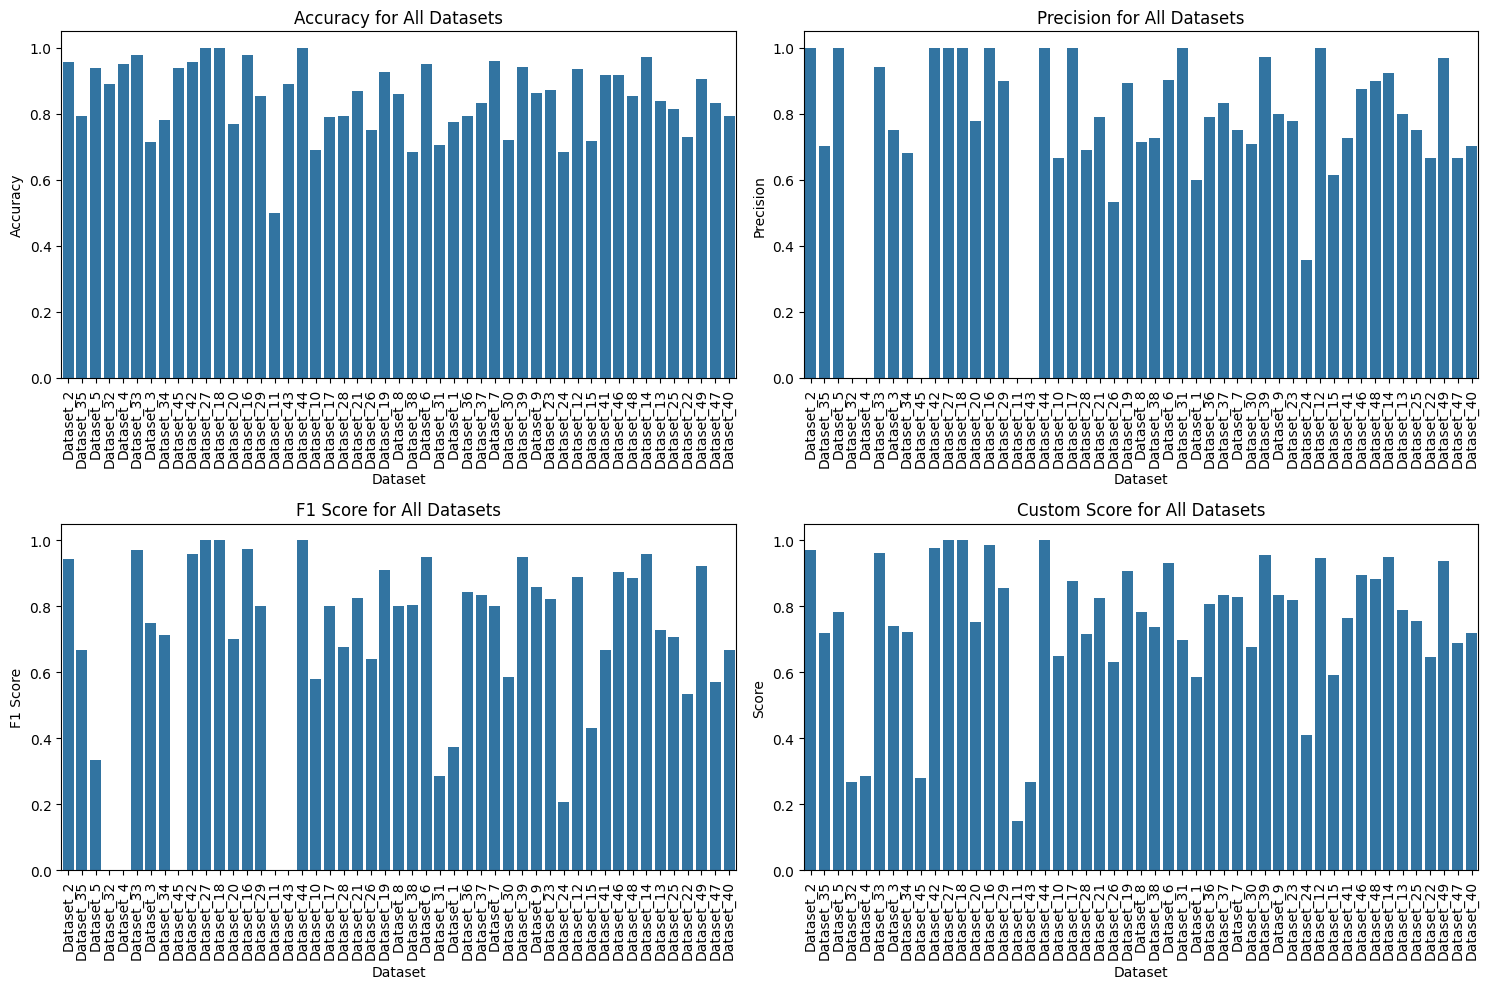

In [4]:
# Visualization Summary Chart for All Datasets
summary_df = pd.DataFrame(summary_metrics)
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.barplot(data=summary_df, x='Dataset', y='Accuracy')
plt.title('Accuracy for All Datasets')
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
sns.barplot(data=summary_df, x='Dataset', y='Precision')
plt.title('Precision for All Datasets')
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
sns.barplot(data=summary_df, x='Dataset', y='F1 Score')
plt.title('F1 Score for All Datasets')
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
sns.barplot(data=summary_df, x='Dataset', y='Score')
plt.title('Custom Score for All Datasets')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()
